# PREGUNTAS Y RESPUESTAS CON BERT
![](https://i0.wp.com/linkskorner.com/wp-content/uploads/2018/12/question-answer-sites-list.jpg?fit=2560%2C1440&ssl=1)

##1 - El problema a resolver

La idea es implementar un modelo que dada una **pregunta** y un **contexto** (una porción de texto), sea capaz de encontrar la **respuesta** correspondiente

##2- Arquitectura del modelo

Para esto tomaremos el modelo *BERT BASE* pre-entrenado, agregaremos algunas capas adicionales, y lo **afinaremos** para que aprenda a encontrar la respuesta dados un contexto y una pregunta como entrada:

![](https://lilianweng.github.io/posts/2020-10-29-odqa/BERT-RC.png)

##3- Librerías importantes

Dada la complejidad del modelo, y la imposibilidad de entrenarlo con los recursos proporcionados por Google Colab, usaremos un [*Tokenizer*](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html#using-a-pretrained-tokenizer) y un [modelo BERT pre-entrenado](https://huggingface.co/bert-base-uncased).

In [ ]:
# Instalar librerías importantes
!pip install transformers
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##4- El set de datos

Usaremos el set [SQuAD v1.1](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/) (*Stanford Question Answering Dataset*), que contiene más de 100.000 pares de preguntas-respuestas.

Cada ejemplo de entrenamiento contiene estas variables:

1. `context`: el texto completo (contexto)
2. `question`: una pregunta acerca del contenido del contexto
3. `answer_text`: el texto dentro del contexto que responde la pregunta
4. `start_char_idx`: el caracter dentro del contexto en donde inicia la respuesta
5. `all_answers`: todos los posibles textos de respuesta (en caso de que la respuesta aparezca varias veces dentro del contexto)

###4.1- Lectura de los sets de datos

Los sets están almacenados en dos diccionarios de Python `raw_train_dataset` (set de entrenamiento) y `raw_test_dataset` (set de prueba):

In [ ]:
# Importar Google Drive
from google.colab import drive
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Y leer los datasets (entrenamiento y prueba)
ruta = '/content/drive/MyDrive/12 Machine Learning/data'

with open(ruta+'/raw_train_dataset.pkl','rb') as handle:
  raw_train_dataset = pickle.load(handle)

with open(ruta+'/raw_test_dataset.pkl','rb') as handle:
  raw_test_dataset = pickle.load(handle)

print(f'Número de ejemplos de entrenamiento: {len(raw_train_dataset)}')
print(f'Número de ejemplos de prueba: {len(raw_test_dataset)}')

Número de ejemplos de entrenamiento: 87599
Número de ejemplos de prueba: 10570


Veamos un ejemplo de entrenamiento:

In [ ]:
import textwrap

# Ejemplo
id = 23 #12
context = raw_train_dataset[id]['context']
question = raw_train_dataset[id]['question']
start_char_idx = raw_train_dataset[id]['start_char_idx']
answer_text = raw_train_dataset[id]['answer_text']
all_answers = raw_train_dataset[id]['all_answers']

print('Contexto (context):')
print('--------------')
print(textwrap.fill(context,width=90))

print('\nPregunta (question):')
print('--------------')
print(textwrap.fill(question,width=90))

print('\nTexto de respuesta (answer_text):')
print('-------------------')
print(textwrap.fill(answer_text,width=90))

print('\nÍndice del caracter de inicio de la respuesta (start_char_idx):')
print('----------------------------------------------')
print(start_char_idx, context[start_char_idx:start_char_idx+10]+'...')

print('\nTodas las posibles respuestas (all_answers):')
print('-------------------------------')
print(all_answers)

Contexto (context):
--------------
All of Notre Dame's undergraduate students are a part of one of the five undergraduate
colleges at the school or are in the First Year of Studies program. The First Year of
Studies program was established in 1962 to guide incoming freshmen in their first year at
the school before they have declared a major. Each student is given an academic advisor
from the program who helps them to choose classes that give them exposure to any major in
which they are interested. The program also includes a Learning Resource Center which
provides time management, collaborative learning, and subject tutoring. This program has
been recognized previously, by U.S. News & World Report, as outstanding.

Pregunta (question):
--------------
Which organization declared the First Year of Studies program at Notre Dame "outstanding?"

Texto de respuesta (answer_text):
-------------------
U.S. News & World Report

Índice del caracter de inicio de la respuesta (start_char_idx):
---

###4.2- Tokenización

La "tokenización" permite tomar una frase y separararla en sus elementos básicos (palabras o *tokens*) y luego representar cada *token* numéricamente.

Usaremos [BertWordPieceTokenizer](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html#using-a-pretrained-tokenizer), un modelo pre-entrenado para la tokenización de frases en Inglés y adaptado a las necesidades de BERT:

In [ ]:
from tokenizers import BertWordPieceTokenizer

# Cargar el vocabulario
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt

# Y crear el tokenizer
tokenizer = BertWordPieceTokenizer("bert-base-uncased-vocab.txt", lowercase=True)

--2023-03-06 03:00:24--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.97.30, 54.231.161.64, 52.217.167.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.97.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  --.-KB/s    in 0.09s   

2023-03-06 03:00:24 (2.50 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



In [ ]:
# Info del tokenizer
tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

Veamos un ejemplo de tokenización (los *tokens* desconocidos serán codificados con `[UNK]`):

In [ ]:
# Un ejemplo de tokenización
frase = "I am so, so happy 😊!"
salida = tokenizer.encode(frase)

print(f'Frase original:\t\t\t{frase}')
print(f'Tokens:\t\t\t\t{salida.tokens}')
print(f'Representación numérica:\t{salida.ids}')
print(f'Máscara atencional:\t\t{salida.attention_mask}')
print(f'Offsets:\t\t\t{salida.offsets}') # Inicio/finalización de cada token en la sec. de caracteres original

Frase original:			I am so, so happy 😊!
Tokens:				['[CLS]', 'i', 'am', 'so', ',', 'so', 'happy', '[UNK]', '!', '[SEP]']
Representación numérica:	[101, 1045, 2572, 2061, 1010, 2061, 3407, 100, 999, 102]
Máscara atencional:		[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Offsets:			[(0, 0), (0, 1), (2, 4), (5, 7), (7, 8), (9, 11), (12, 17), (18, 19), (19, 20), (0, 0)]


El atributo `offsets` indica el inicio y finalización de cada *token* en la secuencia de caracteres original. Ejemplo:

In [ ]:
# Ejemplo offsets: "happy" es el 6º token
start = salida.offsets[6][0]
end = salida.offsets[6][1]
palabra = frase[start:end]
print(palabra)

happy


###4.3- Pre-procesamiento del dataset

Cada dato (de entrenamiento o prueba) debe ser pre-procesado para obtener los arreglos:

1. `input_ids`: codificación numérica de los tokens `context`+`question`
2. `token_type_ids`: secuencia (del mismo tamaño de `input_ids`) indicando la porción correspondiente a `context` (codificada con 1s), `answer` (codificada con 0s) y "padding" (también con 0s)
3. `attention_mask`: la máscara atencional (del mismo tamaño de `input_ids`) indicando la porción correspondiente a `context`+`answer` (codificada con 1s) y la porción que contiene "padding" (codificada con 0s)
4. `start_token_idx`: la posición del token de inicio de la respuesta, con respecto a la secuencia `input_ids`
5. `end_token_idx`: la posición del token de finalización de la respuesta, con respecto a la secuencia `input_ids`

Durante el entrenamiento, los datos 1 a 3 se usarán como entrada al modelo, y este deberá a aprender a predecir los datos 4 y 5.

In [ ]:
# Longitud máxima de cada secuencia de entrada al modelo.
# Si la longitud de la secuencia procesada es inferior se agrega "padding",
# de lo contrario se trunca y no se incluye en el set
MAX_LEN = 384

def preprocesar(dato):
  # Extraer componentes del dato
  context = dato['context']
  question = dato['question']
  answer_text = dato['answer_text']
  start_char_idx = dato['start_char_idx']

  # Eliminar posibles excesos de espacios en blanco
  context = " ".join(str(context).split())
  question = " ".join(str(question).split())
  answer = " ".join(str(answer_text).split())

  # Encontrar el índice del caracter de finalización de la respuesta
  end_char_idx = start_char_idx + len(answer)

  # Algunas respuestas están indexadas incorrectamente. De ser así
  # saltar el dato (no continuar con su procesamiento)
  if end_char_idx >= len(context):
    return #skip: en este caso el dato quedará preprocesado como "None"
  
  # Máscara con los índices en "context" correspondientes a "answer"
  is_char_in_ans = [0] * len(context)
  for idx in range(start_char_idx, end_char_idx):
    is_char_in_ans[idx] = 1
  
  # Tokenizar "context"
  tokenized_context = tokenizer.encode(context)

  # Encontrar equivalencia entre caracteres inicio/finalización de
  # respuesta y los tokens de inicio/finalización de respuesta
  ans_token_idx = []
  for idx, (start, end) in enumerate(tokenized_context.offsets):
    if sum(is_char_in_ans[start:end]) > 0: # si la porción analizada es "answer"
      ans_token_idx.append(idx)
  
  # Para respuestas indexadas incorrectamente: si no se encuentran tokens de
  # inicio/finalización de respuesta, saltar el dato
  if len(ans_token_idx) == 0:
    return #skip: en este caso el dato quedará preprocesado como "None"
  
  # De lo contrario almacenar los tokens de inicio/finalización de respuesta
  start_token_idx = ans_token_idx[0]
  end_token_idx = ans_token_idx[-1]

  # Tokenizar "question"
  tokenized_question = tokenizer.encode(question)

  # Crear frase de entrada al modelo:
  #[[CLS] tk_ctxt1 tk_ctxt2 ... [SEP] tk_qst1 + tk_qst2 + ... [SEP]]
  input_ids = tokenized_context.ids + tokenized_question.ids[1:]

  # Máscara atencional: el modelo prestará atención sólo a "context" y a
  # "question", pero no al "padding"
  attention_mask = [1] * len(input_ids)

  # Máscara: 0 para "context" y 1 para "question"
  token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
      tokenized_question.ids[1:])
  
  # Padding
  padding_length = MAX_LEN - len(input_ids)
  if padding_length > 0: # Agregar "padding"
    input_ids = input_ids + ([0] * padding_length)
    
    # Actualizar máscaras, enmascarando (haciendo 0) la
    # porción correspondiente al "padding"
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)
  elif padding_length < 0: # La secuencia debe ser truncada, saltarla
    return #skip: en este caso el dato quedará preprocesado como "None"
  
  # Conformar diccionario de salida
  seq_preprocessed = {
      'input_ids': input_ids,
      'token_type_ids': token_type_ids,
      'attention_mask': attention_mask,
      'start_token_idx': start_token_idx,
      'end_token_idx': end_token_idx,
      'context_token_to_char': tokenized_context.offsets
  }

  return seq_preprocessed

In [ ]:
# Imprimir un ejemplo de pre-procesamiento
dato = raw_train_dataset[0]
seq_preproc = preprocesar(dato)

if type(seq_preproc) != None:
  print('input_ids:\n---------------- ')
  print(textwrap.fill(str(seq_preproc['input_ids']),width=125))
  print('\ntoken_type_ids:\n---------------- ')
  print(textwrap.fill(str(seq_preproc['token_type_ids']),width=125))
  print('\nattention_mask:\n---------------- ')
  print(textwrap.fill(str(seq_preproc['attention_mask']),width=125))
  print('\nstart_token_idx:\n---------------- ')
  print(seq_preproc['start_token_idx'])
  print('\nend_token_idx:\n---------------- ')
  print(seq_preproc['end_token_idx'])
  print('\ncontext_token_to_char:\n----------------')
  print(seq_preproc['context_token_to_char'])

input_ids:
---------------- 
[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003,
1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037,
6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267,
1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003,
1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052,
2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711,
2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017,
11342, 1998, 1996, 2751, 8514, 1007, 1010, 2003, 1037, 3722, 1010, 2715, 2962, 6231, 1997, 2984, 1012, 

Finalmente crearemos la función `crear_ejemplos_squad` para que pre-procese la totalidad de los datos de entrenamiento y prueba:

In [ ]:
def crear_ejemplos_squad(raw_dataset):
  squad_examples = []
  for item in raw_dataset:
    squad_example = preprocesar(item)
    squad_examples.append(squad_example)
  
  return squad_examples

train_squad_examples = crear_ejemplos_squad(raw_train_dataset)
test_squad_examples = crear_ejemplos_squad(raw_test_dataset)

###4.4- Sets de entrenamiento y prueba

Por cada ejemplo de entrenamiento y prueba, conformar los arreglos `x` (entrada al modelo) y `y` (salida del modelo):

- `x`: conformado por `input_ids`, `token_type_ids` y `attention_mask`
- `y`: conformado por `start_token_idx` y `end_token_idx`

In [ ]:
import numpy as np

def crear_entradas_salidas(squad_examples):
  dataset_dict = {
      'input_ids': [], #entrada
      'token_type_ids': [], #entrada
      'attention_mask': [], #entrada
      'start_token_idx': [], #salida
      'end_token_idx': [], #salida
  }
  for item in squad_examples:
    # Incluir únicamente datos sin errores
    if item != None:
      # Llenar el diccionario
      for key in dataset_dict:
        dataset_dict[key].append(item[key])
    
  # Convertir listas a arreglos de Numpy
  for key in dataset_dict:
    dataset_dict[key] = np.array(dataset_dict[key])
      
  # Conformar arreglos "x" y "y"
  x = [
       dataset_dict["input_ids"],
       dataset_dict["token_type_ids"],
       dataset_dict["attention_mask"]
       ]
  y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
  return x, y

# Y crear los sets de entrenamiento y prueba
x_train, y_train = crear_entradas_salidas(train_squad_examples)
x_test, y_test = crear_entradas_salidas(test_squad_examples)

In [ ]:
# Número de datos de entrenamiento/prueba iniciales (antes del pre-procesamiento)
# y definitivos (que se usarán para entrenar/validar el modelo)

print(f'Datos de entrenamiento iniciales/finales: {len(train_squad_examples)}/{x_train[0].shape[0]}')
print(f'Datos de prueba iniciales/finales: {len(test_squad_examples)}/{x_test[0].shape[0]}')

Datos de entrenamiento iniciales/finales: 87599/86136
Datos de prueba iniciales/finales: 10570/10331


Los sets de entrenamiento (`x_train`, `y_train`) y prueba (`x_test`,`y_test`) están organizados de esta forma:

- `x_train[0][id]`, `x_test[0][id]`: `input_ids` para el dato `id`
- `x_train[1][id]`, `x_test[1][id]`: `token_type_ids` para el dato `id`
- `x_train[2][id]`, `x_test[2][id]`: `attention_mask` para el dato `id`
- `y_train[0][id]`, `y_test[0][id]`: `start_token_id` para el dato `id`
- `y_train[1][id]`, `y_test[1][id]`: `end_token_id` para el dato `id`

##5- Creación del modelo

Usando la librería `transformers` de Hugging Face, implementaremos la arquitectura descrita en la sección 2 del Notebook:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFBertModel, BertConfig

# Semilla del generador aleatorio
SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros por defecto para la configuración de BERT
configuration = BertConfig()
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
def crear_modelo():
  # Modelo base pre-entrenado (BERT base)
  bert_base = TFBertModel.from_pretrained("bert-base-uncased")

  # Entradas
  input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
  token_type_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
  attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

  # Conectar entradas a BERT
  x = bert_base(
      input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
  )[0]

  # Agregar capas adicionales

  # FCN 1: FCN posición token de inicio
  fcn_start = layers.Dense(1, name='fcn_start', use_bias=False)(x)
  fcn_start = layers.Flatten(name='fcn_start_flatten')(fcn_start)

  # FCN 2: FCN posición token de finalización
  fcn_end = layers.Dense(1, name='fcn_end', use_bias=False)(x)
  fcn_end = layers.Flatten(name='fcn_end_flatten')(fcn_end)
  
  # Capas softmax
  start_softmax = layers.Activation(keras.activations.softmax, name='start_softmax')(fcn_start)
  end_softmax = layers.Activation(keras.activations.softmax, name='end_softmax')(fcn_end)

  # Crear el modelo interconectando todos los elementos
  modelo = keras.Model(
      inputs = [input_ids, token_type_ids, attention_mask], #3 entradas por cada ejemplo
      outputs = [start_softmax, end_softmax] #2 salidas por cada ejemplo
  )

  # Opcional: congelar la capa que contiene el modelo BERT pre-entrenado (capa 3)
  modelo.layers[3].trainable = True

  # Compilar el modelo
  loss = keras.losses.SparseCategoricalCrossentropy()
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)
  #optimizer = keras.optimizers.Adam(learning_rate=0.001)
  modelo.compile(optimizer=optimizer, loss=[loss, loss])
  
  #loss_function = SparseCategoricalCrossentropy(from_logits=True)
  #optimizer = Adam(learning_rate=0.001)
  #modelo.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  
  return modelo

Teniendo en cuenta el elevado número de parámetros que se deben aprender, es recomendable usar la TPU para el entrenamiento: *Runtime* -> *Change runtime type* -> *Hardware accelerator* -> *TPU*.

Configuremos la TPU y creemos el modelo:

In [ ]:
# Configurar la TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# Y crear el modelo
with strategy.scope():
  modelo = crear_modelo()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Imprimamos en pantalla las características del modelo y verifiquemos que el modelo *BERT base* tiene aproximadamente 110 millones de parámetros:

In [ ]:
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 384)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 384)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 384)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

Veamos la arquitectura que acabamos de construir:

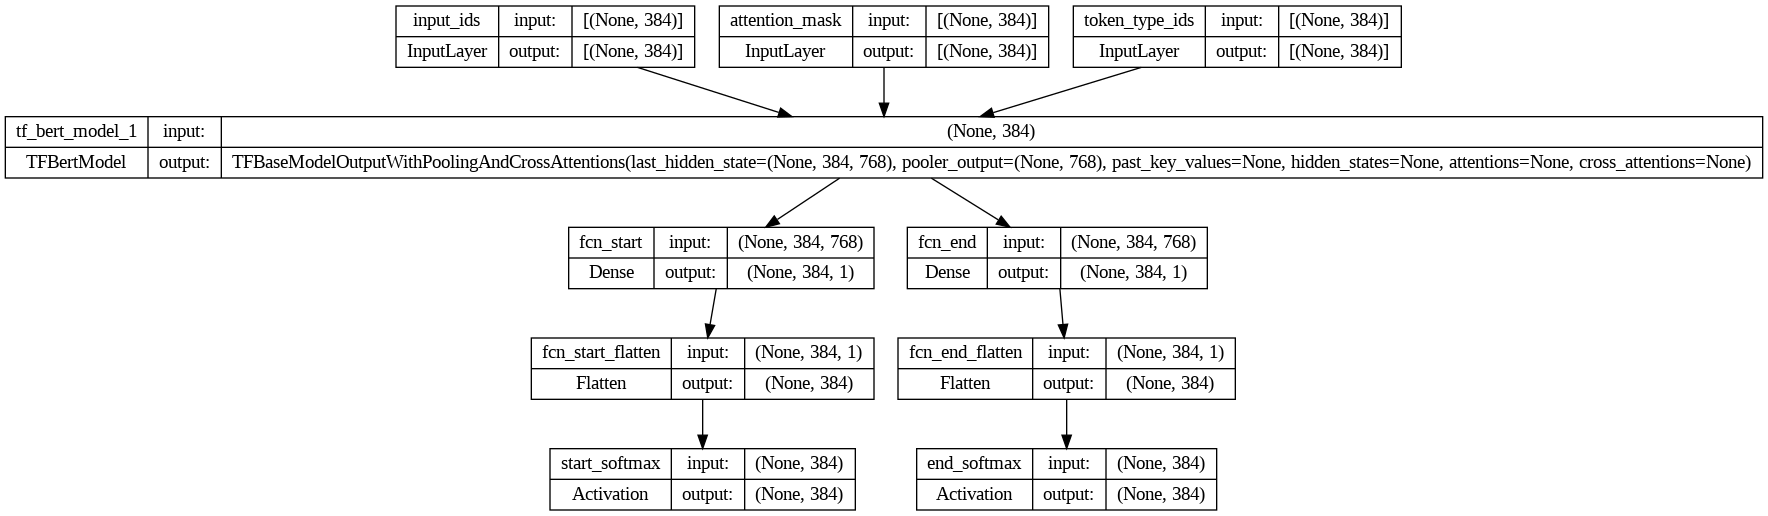

In [ ]:
# Dibujar modelo
from keras.utils.vis_utils import plot_model
plot_model(modelo, to_file='modelo.png', show_shapes=True, show_layer_names=True)

##6- Entrenamiento del modelo

In [ ]:
# Importante: crear diccionarios de entrenamiento usando
# la misma nomenclatura usada al momento de la creación del modelo
X_train = {
    'input_ids': x_train[0],
    'token_type_ids': x_train[1],
    'attention_mask': x_train[2]
}
Y_train = {
    'start_softmax': y_train[0],
    'end_softmax': y_train[1]
}

X_test = {
    'input_ids': x_test[0],
    'token_type_ids': x_test[1],
    'attention_mask': x_test[2]
}
Y_test = {
    'start_softmax': y_test[0],
    'end_softmax': y_test[1]
}

# Entrenamiento
modelo.fit(
    X_train,
    Y_train,
    epochs=3,
    verbose=2,
    batch_size=32,
    validation_data = (X_test,Y_test)
)

# El entrenamiento requiere aproximadamente 10 min/epoch

Epoch 1/3


2692/2692 - 521s - loss: 2.4637 - start_softmax_loss: 1.2903 - end_softmax_loss: 1.1734 - val_loss: 1.9624 - val_start_softmax_loss: 1.0198 - val_end_softmax_loss: 0.9427 - 521s/epoch - 194ms/step
Epoch 2/3
2692/2692 - 350s - loss: 1.5273 - start_softmax_loss: 0.8130 - end_softmax_loss: 0.7142 - val_loss: 2.0352 - val_start_softmax_loss: 1.0517 - val_end_softmax_loss: 0.9835 - 350s/epoch - 130ms/step
Epoch 3/3
2692/2692 - 347s - loss: 1.0829 - start_softmax_loss: 0.5815 - end_softmax_loss: 0.5015 - val_loss: 2.1702 - val_start_softmax_loss: 1.1316 - val_end_softmax_loss: 1.0386 - 347s/epoch - 129ms/step


In [ ]:
# Save the trained model to Google Drive
modelo.save('/content/drive/MyDrive/12 Machine Learning/modelo/my_model_Q_A.h5')

##7- Predicción: preguntas y respuestas

Primero verificaremos el desempeño con los sets de entrenamiento y prueba, y después lo haremos con un nuevo dato nunca antes visto por el modelo.

###7.1- Predicción con ejemplos de entrenamiento y prueba

In [ ]:
def preprocesar_dato(ctxt, ques):
  # Eliminar posibles excesos de espacios en blanco
  context = " ".join(str(ctxt).split())
  question = " ".join(str(ques).split())

  # Tokenizar "context" y "question"
  tokenized_context = tokenizer.encode(context)
  tokenized_question = tokenizer.encode(question)

  # Crear frase de entrada al modelo:
  #[[CLS] tk_ctxt1 tk_ctxt2 ... [SEP] tk_qst1 + tk_qst2 + ... [SEP]]
  input_ids = tokenized_context.ids + tokenized_question.ids[1:]

  # Máscara atencional
  attention_mask = [1] * len(input_ids)

  # Máscara: 0 para "context" y 1 para "question"
  token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
      tokenized_question.ids[1:])
  
  # Padding
  padding_length = MAX_LEN - len(input_ids)
  if padding_length > 0: # Agregar "padding"
    input_ids = input_ids + ([0] * padding_length)
    
    # Actualizar máscara atencional, enmascarando (haciendo 0) la
    # porción correspondiente al "padding"
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)
    
  # Conformar diccionario de salida
  x = {
      'input_ids': np.array(input_ids).reshape(1,MAX_LEN),
      'token_type_ids': np.array(token_type_ids).reshape(1,MAX_LEN),
      'attention_mask': np.array(attention_mask).reshape(1,MAX_LEN)
  }
  

  return x, tokenized_context

In [ ]:
def predecir_respuesta(ctxt, ques, print_flag=True):
  #x, ques_tk_length, tk_context = preprocesar_dato(ctxt,ques)
  
  x, tk_context = preprocesar_dato(ctxt,ques)

  start_token_probs, end_token_probs = modelo(x)
  
  start_token_id = np.argmax(start_token_probs)
  end_token_id = np.argmax(end_token_probs)

  # Pasar the token_ids a posiciones en la secuencia original
  context_start_id = tk_context.token_to_chars(start_token_id)[0]
  context_end_id = tk_context.token_to_chars(end_token_id)[1]

  # Generar e imprimir la predicción
  resp = context[context_start_id:context_end_id]
  if print_flag:
    print('\nRespuesta (predicción):\n--------------')
    print(resp)

  return resp

In [ ]:
# Predicciones con el set de entrenamiento (o prueba)
id = 1000
#dato = raw_train_dataset[id]
dato = raw_test_dataset[id]
question = dato['question']
context = dato['context']
answer = dato['answer_text']

print('Contexto:\n--------------')
print(textwrap.fill(context,width=130))

print('\nPregunta:\n--------------')
print(question)

print('\nRespuesta (target):\n--------------')
print(answer)

# Respuesta predicha
respuesta = predecir_respuesta(context,question)

Contexto:
--------------
Other green spaces in the city include the Botanic Garden and the University Library garden. They have extensive botanical
collection of rare domestic and foreign plants, while a palm house in the New Orangery displays plants of subtropics from all over
the world. Besides, within the city borders, there are also: Pole Mokotowskie (a big park in the northern Mokotów, where was the
first horse racetrack and then the airport), Park Ujazdowski (close to the Sejm and John Lennon street), Park of Culture and Rest
in Powsin, by the southern city border, Park Skaryszewski by the right Vistula bank, in Praga. The oldest park in Praga, the Praga
Park, was established in 1865–1871 and designed by Jan Dobrowolski. In 1927 a zoological garden (Ogród Zoologiczny) was
established on the park grounds, and in 1952 a bear run, still open today.

Pregunta:
--------------
Where is a palm house with subtropic plants from all over the world on display?

Respuesta (target):
---------

###7.2- Predicción con un dato nuevo

Usaremos una porción de texto con la descripción de la película [Ciudadano Kane](https://en.wikipedia.org/wiki/Citizen_Kane), tomada de Wikipedia.

Primero crearemos una función para mostrar la predicción al estilo de Google:

In [ ]:
from IPython.core.display import HTML

def mostrar_prediccion(ctxt, ques, answer):
  # Predecir la respuesta usando la función creada anteriormente
  res = predecir_respuesta(ctxt, ques, print_flag=False)

  # Imprimir pregunta y respuesta real en formato HTML
  display(HTML(f'<h3>Pregunta: {ques}</h3'))
  display(HTML(f'<h3>Respuesta (target): {answer}</h3'))

  # Imprimir contexto y resaltar la respuesta predicha por el modelo
  texto_resaltado = str(context.replace(res, f'<mark>{res}</mark>'))
  display(HTML(f'''<blockquote> {texto_resaltado} </blockquote>'''))

In [ ]:
# Predicción sobre otro texto

context = 'In a mansion called Xanadu, part of a vast palatial estate in Florida, the elderly Charles Foster Kane is on his deathbed. Holding a snow globe, he utters a word, Rosebud, and dies. A newsreel obituary tells the life story of Kane, an enormously wealthy newspaper publisher and industrial magnate. Kane''s death becomes sensational news around the world, and the newsreel''s producer tasks reporter Jerry Thompson with discovering the meaning of Rosebud.'

#question = 'What is the name of the mansion?'
#answer = 'Xanadu'
#question = 'Which was the last word pronounced by Charles Foster Kane?'
#answer = 'Rosebud'
#question = 'Who is in charge of finding the meaning of Rosebud?'
#answer = 'Jerry Thompson'
question = 'Where is Xanadu located?'
answer = 'in Florida'

mostrar_prediccion(context,question,answer)

In [ ]:
context = 'Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides.'
question = "What it Keras?"
answer = "Keras is an API designed for human beings"

#question = "Does Keras have documentation?"
#answer = "It also have extensive documentation and developer guides"

mostrar_prediccion(context,question,answer)

In [ ]:
context = 'Data science is an interdisciplinary academic field that uses statistics, scientific computing, scientific methods, processes, algorithms and systems to extract or extrapolate knowledge and insights from noisy, structured, and unstructured data. Data science also integrates domain knowledge from the underlying application domain e.g., natural sciences, information technology, and medicine. Data science is multifaceted and can be described as a science, a research paradigm, a research method, a discipline, a workflow, and a profession. Data science is a concept to unify statistics, data analysis, informatics, and their related methods in order to understand and analyse actual phenomena with data. It uses techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, information science, and domain knowledge. However, data science is different from computer science and information science. Turing Award winner Jim Gray imagined data science as a fourth paradigm of science empirical, theoretical, computational, and now data-driven and asserted that everything about science is changing because of the impact of information technology and the data deluge. A data scientist is the professional who creates programming code and combines it with statistical knowledge to create insights from data.'

#question = "What is Data science?"
#answer = "Data science is an interdisciplinary academic field"

#question = "What integrates Data science?"
#answer = "integrates domain knowledge"

question = "Who is Jim Gray?"
answer = "Turing Award winner"


mostrar_prediccion(context,question,answer)